<a href="https://colab.research.google.com/github/bkalambe-12/shot-classifier/blob/main/classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import glob

In [4]:
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle

In [5]:
!kaggle datasets download -d aneesh10/cricket-shot-dataset

 98% 633M/645M [00:21<00:00, 41.2MB/s]
100% 645M/645M [00:21<00:00, 31.7MB/s]


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cricket-shot-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
TRAIN_DIR = "./DATASET"

ORG_DIR = "./content/train"

CLASS = ['drive','legglance-flick','pullshot','sweep']

In [9]:
for C in CLASS:
  DEST = os.path.join(TRAIN_DIR,C)

   # if directory is mot present hen create one
  if not os.path.exists( DEST):
    os.makedirs(DEST)

    for img_path in glob.glob(os.path.join(ORG_DIR , C)+"*"):
      SRC = img_path

      shutil.copy(SRC , DEST)

# Model Building


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import keras


In [11]:
base_model = InceptionV3(input_shape=(256,256,3), include_top= False)

87910968/87910968 [==============================] - 0s 0us/step


In [12]:
for layer in base_model.layers:
  layer.trainable = False

In [13]:
X = Flatten()(base_model.output)
X = Dense(units=4, activation='sigmoid')(X)

#final model
model = Model(base_model.input , X)

#compile the model
model.compile(optimizer='adam', loss= keras.losses.binary_crossentropy, metrics=['accuracy'])


#summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

#Pre-Process data using Data Generator


In [14]:
train_datagen = ImageDataGenerator(featurewise_center= True ,
                                   rotation_range= 0.4,
                                   width_shift_range= 0.3,
                                   horizontal_flip= True, 
                                   preprocessing_function= preprocess_input, 
                                   zoom_range= 0.4, 
                                   shear_range= 0.4
                                   )
train_data = train_datagen.flow_from_directory(directory= "/content/data", 
                                               target_size=(256,256),
                                               batch_size=64)

Found 4723 images belonging to 4 classes.


In [15]:
train_data.class_indices

{'drive': 0, 'legglance-flick': 1, 'pullshot': 2, 'sweep': 3}

#Visualizing the data


In [16]:
 t_img , label= train_data.next()

In [17]:
def plotImages(img_arr , label):
   """
   input : image array
   output : plot images
   """

   for idx , img in enumerate( img_arr):

     if idx <= 10:

       plt.figure(figsize=(5,5))
       plt.imshow(img)
       plt.title(img.shape)
       plt.axis = False
       plt.show()

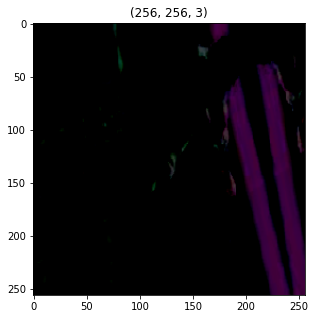

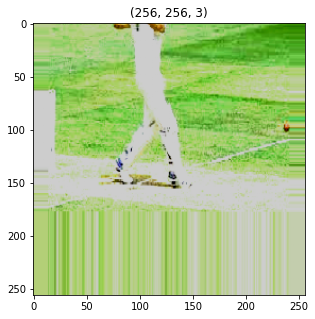

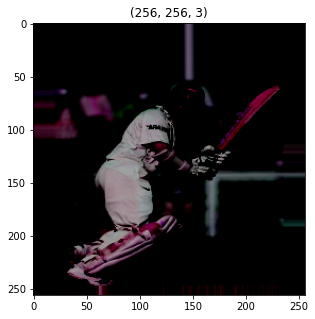

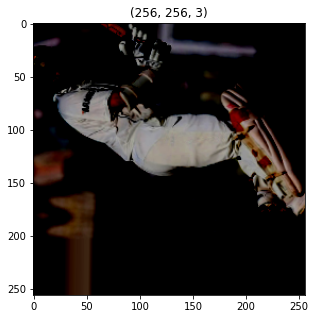

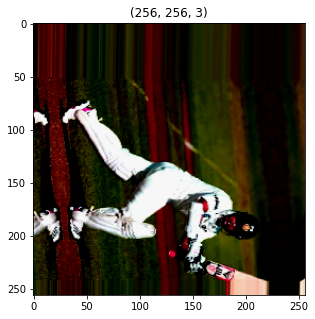

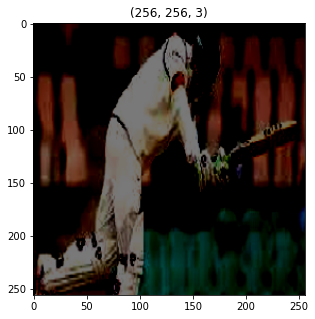

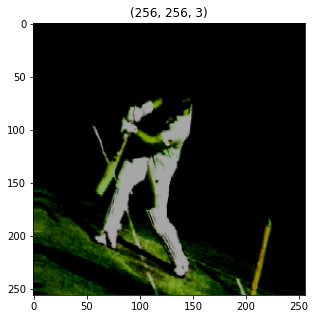

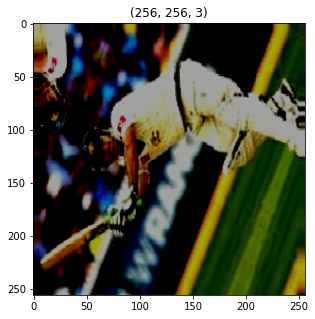

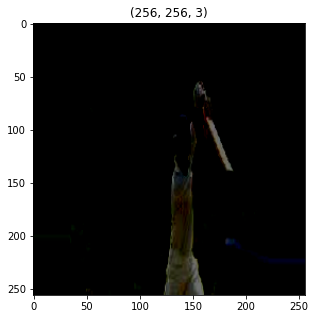

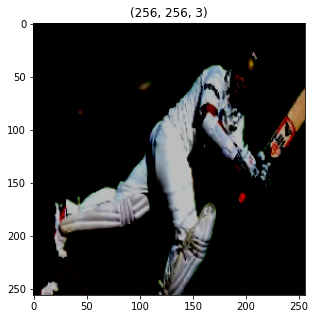

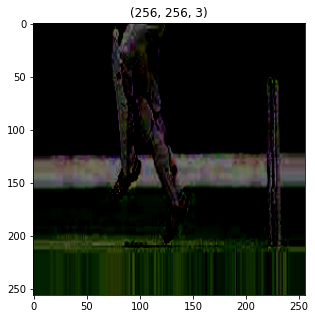

In [18]:
plotImages(t_img , label)

#Model Check Point


In [19]:
from keras.callbacks import ModelCheckpoint , EarlyStopping

mc = ModelCheckpoint(filepath= "./best_model.h5",
                     monitor="accuracy",
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor="accuracy", 
                   min_delta=0.01,
                   patience=5,
                   verbose=1)

cb=[mc,es]

In [20]:
his= model.fit_generator(train_data,
                         steps_per_epoch=10,
                         epochs=30,
                         callbacks=cb)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 4.2915 - accuracy: 0.3344
Epoch 1: accuracy improved from -inf to 0.33437, saving model to ./best_model.h5
10/10 [==============================] - 24s 1s/step - loss: 4.2915 - accuracy: 0.3344
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 2.4326 - accuracy: 0.4912
Epoch 2: accuracy improved from 0.33437 to 0.49123, saving model to ./best_model.h5
10/10 [==============================] - 12s 1s/step - loss: 2.4326 - accuracy: 0.4912
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.5266
Epoch 3: accuracy improved from 0.49123 to 0.52656, saving model to ./best_model.h5
10/10 [==============================] - 13s 1s/step - loss: 1.4427 - accuracy: 0.5266
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6562
Epoch 4: accuracy improved from 0.52656 to 0.65625, saving model to ./best_model.h5
10/10 [=======================

In [21]:
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [22]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy'])

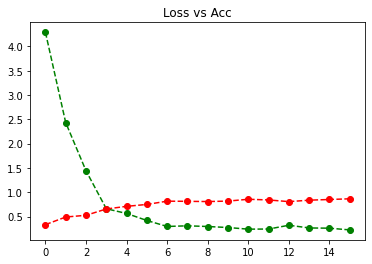

In [27]:
plt.plot(h['loss'],  'go--')
plt.plot(h['accuracy'], 'go--'  ,c= "red",)

plt.title("Loss vs Acc")
plt.show()

# Validate our model





1/1 [==============================] - 0s 25ms/step


The image is of shot SWEEP


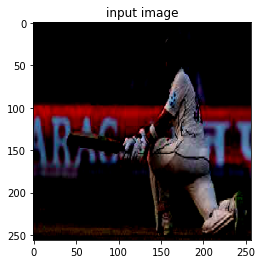

In [59]:
# path for the image to see if it predicts correct class
path = "/content/data/sweep/sweep1008.jpeg"
img = load_img(path,target_size=(256,256))

i=img_to_array(img)

i= preprocess_input(i)

input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

if pred ==0:
  print("The image is of shot DRIVE")
else:
      print("The image is of shot SWEEP")
      
          


# TO DISPLAY THE IMAGE
plt.imshow(input_arr[0])
plt.title("input image")
plt.axis= False
plt.show()